In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import glob
import os
import numpy.ma as ma
import math
from netCDF4 import stringtochar
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
meta_data = pd.read_csv('https://raw.githubusercontent.com/mmaliu97/CW3E_Avalanche_AR/main/snotel_meta_data.csv')
avalanche_data = pd.read_csv('https://raw.githubusercontent.com/mmaliu97/CW3E_Avalanche_AR/main/avalanche_coords_datenum.csv')
avalanche_weather = pd.read_csv('D:/UC DAVIS/CW3E/data/avalanche_data/avalanche_weather.csv')

## Plotting the weather patterns 6 days before and 1 day after the avalanche

### First seperate the data according to states

In [3]:
avalanche_weather

,State,Latitude,Longitude,Date,SWE,Precipitation,Cumulative_Precipitation,Max_Temp,Min_Temp,site_id,distance
0,AK,63.20,-145.63,16411.0,79.0,0.0,97.0,-1.6,-5.4,1268,0.123693
1,AK,63.20,-145.63,16410.0,79.0,0.0,97.0,-4.5,-10.1,1268,0.123693
2,AK,63.20,-145.63,16409.0,79.0,0.0,97.0,-9.6,-22.6,1268,0.123693
3,AK,63.20,-145.63,16408.0,79.0,0.0,97.0,-5.2,-20.9,1268,0.123693
4,AK,63.20,-145.63,16407.0,79.0,0.0,97.0,-4.1,-14.0,1268,0.123693
...,...,...,...,...,...,...,...,...,...,...,...
25707,WY,42.51,-110.91,18673.0,218.0,8.0,246.0,-2.7,-13.7,730,0.580086
25708,WY,42.51,-110.91,18672.0,216.0,3.0,244.0,-8.4,-14.8,730,0.580086
25709,WY,42.51,-110.91,18671.0,211.0,3.0,241.0,0.9,-9.7,730,0.580086
25710,WY,42.51,-110.91,18670.0,201.0,10.0,231.0,2.3,-4.1,730,0.580086


In [4]:
avalanche_weather = avalanche_weather[::-1].reset_index(drop = True)

avalanche_weather_dict = dict(tuple(avalanche_weather.groupby('State')))

## Making a function that sieves dataframes into 8 days

### Note that day 6 is always avalanche day

In [12]:
alaska_weather = avalanche_weather_dict['AK'].reset_index(drop = True)


var_cols = ['SWE', 'Precipitation', 'Cumulative_Precipitation', 'Max_Temp', 'Min_Temp']
var_title = ['SWE (mm)', 'Precipitation (mm)', 'Cumulative_Precipitation (mm)', 'Max_Temp', 'Min_Temp']

day_cols = ['day0', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7']


In [6]:
alaska_weather

,State,Latitude,Longitude,Date,SWE,Precipitation,Cumulative_Precipitation,Max_Temp,Min_Temp,site_id,distance
0,AK,60.96,-149.09,18654.0,747.0,0.0,892.0,-4.4,-12.8,1103,0.549181
1,AK,60.96,-149.09,18655.0,747.0,5.0,892.0,-1.1,-5.6,1103,0.549181
2,AK,60.96,-149.09,18656.0,747.0,0.0,897.0,-0.6,-6.1,1103,0.549181
3,AK,60.96,-149.09,18657.0,747.0,0.0,897.0,-5.0,-8.9,1103,0.549181
4,AK,60.96,-149.09,18658.0,747.0,0.0,897.0,-8.9,-14.4,1103,0.549181
...,...,...,...,...,...,...,...,...,...,...,...
771,AK,63.20,-145.63,16407.0,79.0,0.0,97.0,-4.1,-14.0,1268,0.123693
772,AK,63.20,-145.63,16408.0,79.0,0.0,97.0,-5.2,-20.9,1268,0.123693
773,AK,63.20,-145.63,16409.0,79.0,0.0,97.0,-9.6,-22.6,1268,0.123693
774,AK,63.20,-145.63,16410.0,79.0,0.0,97.0,-4.5,-10.1,1268,0.123693


#### This function generates a dictionary for the weather in the state

In [7]:
def small_df(df):
    day0 = df.loc[0:len(alaska_weather)-7:8].reset_index(drop = True)
    day1 = df.loc[1:len(alaska_weather)-6:8].reset_index(drop = True)
    day2 = df.loc[2:len(alaska_weather)-5:8].reset_index(drop = True)
    day3 = df.loc[3:len(alaska_weather)-4:8].reset_index(drop = True)
    day4 = df.loc[4:len(alaska_weather)-3:8].reset_index(drop = True)
    day5 = df.loc[5:len(alaska_weather)-2:8].reset_index(drop = True)
    day6 = df.loc[6:len(alaska_weather)-1:8].reset_index(drop = True)
    day7 = df.loc[7:len(alaska_weather):8].reset_index(drop = True)
    
    small_df_dict = {'day0': day0, 'day1': day1, 'day2': day2, 'day3': day3, 'day4': day4, 'day5': day5, 
                     'day6': day6, 'day7': day7}
    return small_df_dict

#### Making the dictionary for alaskan weather

In [8]:
alaska_dict = small_df(alaska_weather)

### Making a function to determine average weather variable for a particular day

In [9]:
def weather_avg(variable,df):  
    count = 0
    factor = 0
    for i in range(len(df)):
        if (df[variable][i]) == '--':
            pass
        else:
            count = count + 1
            factor = factor + float(df[variable][i])
    # round to 3 dp
    average = np.round(factor/count,3)
    return average

## Time to plot!

### Start with AK

In [16]:
from scipy.stats import norm


In [21]:
# Creating our ecdf function
def ecdf(data):
    """ 
    This function creates the x and y axis for a ecdf
    plot given the data as input.
    """
    xaxis = np.sort(data)
    yaxis = np.arange(1,len(data)+1)/len(data)
    return xaxis, yaxis

In [41]:
def qc(variable,df):  
    new_df = []
    for i in range(len(df)):
        if (df[variable][i]) == '--':
            pass
        else:
            new_df.append(df[variable][i])
    return new_df

new_df = qc(var_cols[0],alaska_dict[day_cols[0]])

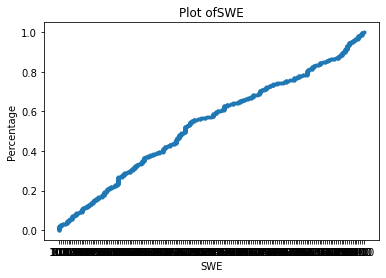

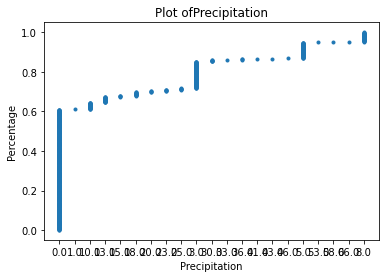

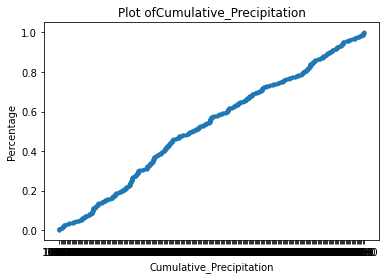

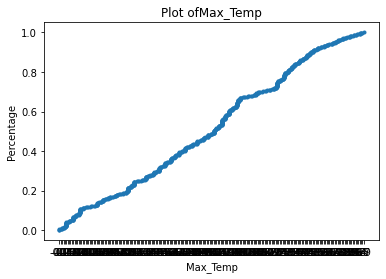

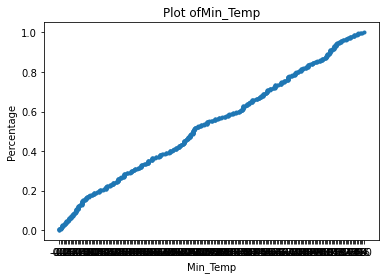

In [55]:
for k in range(len(var_cols)):
    var = var_cols[k]
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = alaska_dict[day]
        new_df = qc(var,df)
        y_val.extend(new_df)
    # Creating the xaxis and yaxis for our ecdf on price
    x,y = ecdf(y_val)
    
    # Plotting our ecdf
    plt.plot(x,y,linestyle='none',marker='.')
    plt.title('Plot of '+ var)
    plt.xlabel(var)
    plt.ylabel('Percentage')
    plt.show()

SWE
Precipitation
Cumulative_Precipitation


C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\si

Max_Temp
Min_Temp


C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\psle1\anaconda3\lib\si

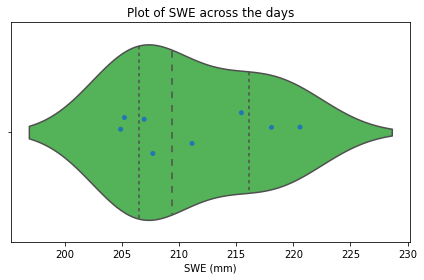

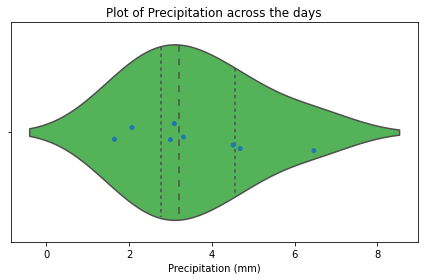

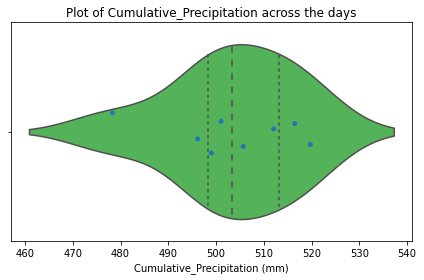

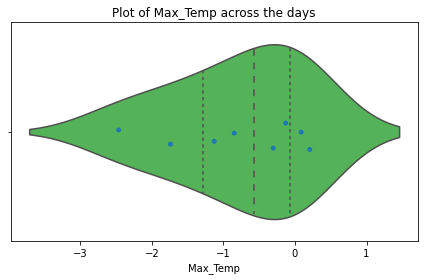

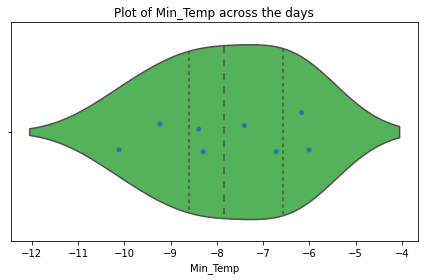

In [18]:
for k in range(len(var_cols)):
    var = var_cols[k]
    print(var)
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = alaska_dict[day]
        average = weather_avg(var,df)
        y_val.append(average)
        
    plt.figure(figsize=(6,4))    
    plt.title('Plot of '+var+' across the days')
    plt.xlabel(var_title[k])
    sns.violinplot(y_val, color='#44C34A',inner='quartiles')
    sns.stripplot(y_val, jitter=True)

    plt.tight_layout();


## Colorado 

SWE


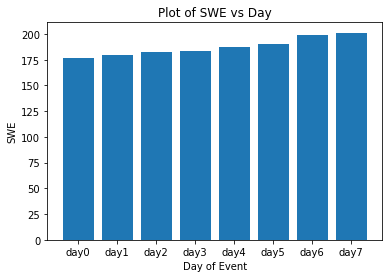

Precipitation


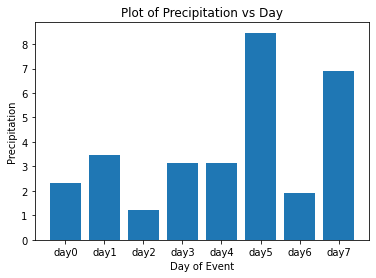

Cumulative_Precipitation


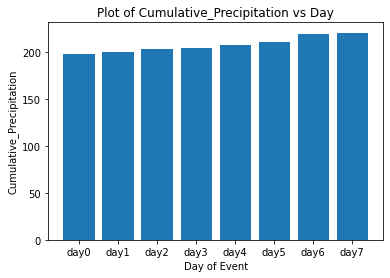

Max_Temp


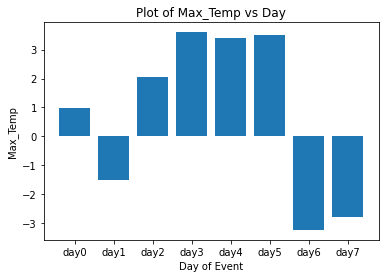

Min_Temp


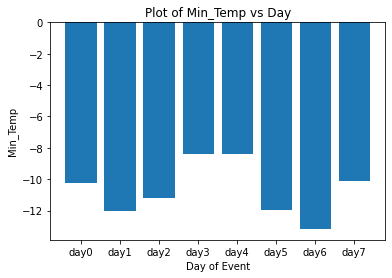

In [72]:
# First extract the state weather
colorado_weather = avalanche_weather_dict['CO'].reset_index(drop = True)

# Next make the dictionary for that state
colorado_dict = small_df(colorado_weather)

# Now we plot!
for k in range(len(var_cols)):
    var = var_cols[k]
    print(var)
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = colorado_dict[day]
        average = weather_avg(var,df)
        y_val.append(average)
        
    plt.bar(day_cols,y_val)
    plt.title('Plot of '+var+' vs Day')
    plt.xlabel('Day of Event')
    plt.ylabel(var)
    plt.show()
    

## Washington

In [50]:
# First extract the state weather
washington_weather = avalanche_weather_dict['WA'].reset_index(drop = True)

# Next make the dictionary for that state
washington_dict = small_df(washington_weather)

# Now we plot!
for k in range(len(var_cols)):
    var = var_cols[k]
    print(var)
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = washington_dict[day]
        average = weather_avg(var,df)
        y_val.append(average)
        
    plt.bar(day_cols,y_val)
    plt.title('Plot of '+var+' vs Day')
    plt.xlabel('Day of Event')
    plt.ylabel(var)
    plt.show()

SWE


ValueError: could not convert string to float: '--'

## Wyoming

SWE


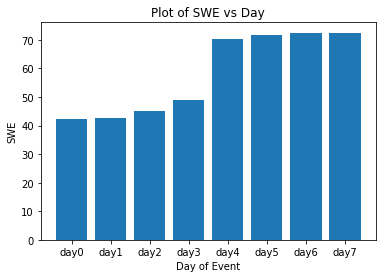

Precipitation


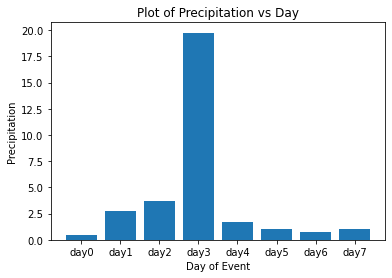

Cumulative_Precipitation


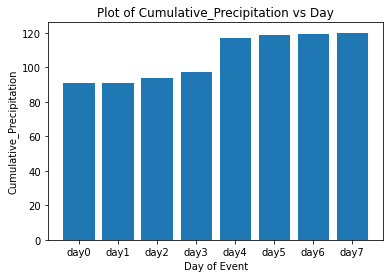

Max_Temp


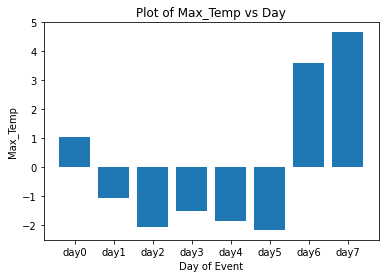

Min_Temp


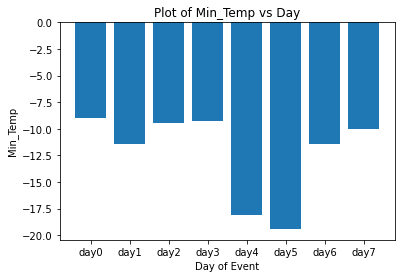

In [14]:
# First extract the state weather
wyoming_weather = avalanche_weather_dict['WY'].reset_index(drop = True)

# Next make the dictionary for that state
wyoming_dict = small_df(wyoming_weather)

# Now we plot!
for k in range(len(var_cols)):
    var = var_cols[k]
    print(var)
    y_val = []
    for n in range(len(day_cols)):
        day = day_cols[n]
        df = wyoming_dict[day]
        average = weather_avg(var,df)
        y_val.append(average)
        
    plt.bar(day_cols,y_val)
    plt.title('Plot of '+var+' vs Day')
    plt.xlabel('Day of Event')
    plt.ylabel(var)
    plt.show()